In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

2.20.0


In [21]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 10

In [22]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 2152 files belonging to 3 classes.


In [23]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

2025-10-26 23:48:03.491012: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


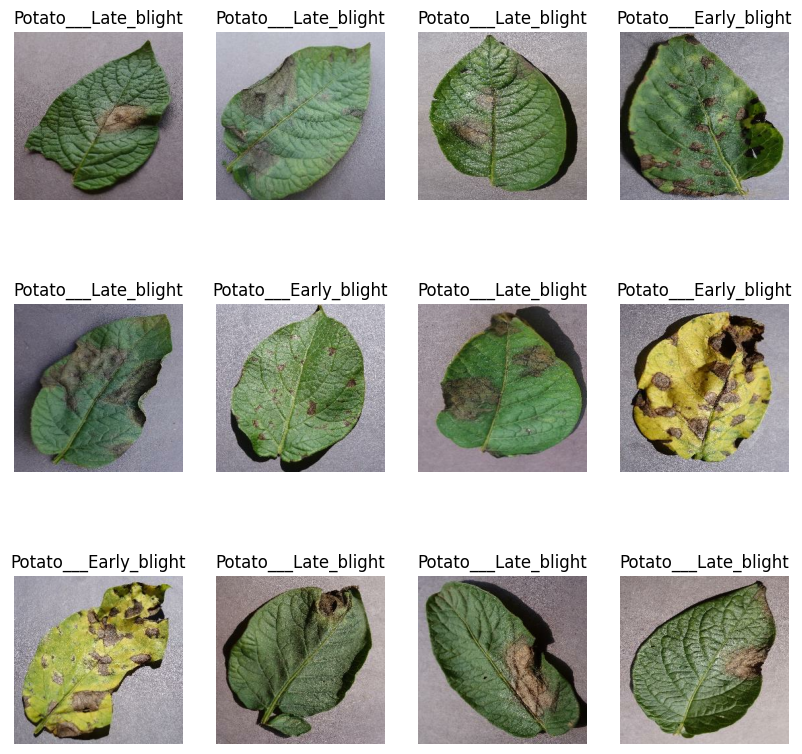

In [24]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [25]:
# 80% training, 10% validation, 10% test
train_dataset = dataset.take(54) #take 80% i.e 54 batch(68 * 0.8)
remain_dataset = dataset.skip(54) # 14 (68-54)
validation_dataset = remain_dataset.take(7) 
test_dataset = remain_dataset.skip(7)

In [26]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [27]:
train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(dataset);

In [28]:
len(train_dataset)

54

In [29]:
len(validation_dataset)

6

In [30]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
IMAGE_SIZE = 256
CHANNELS = 3 # For RGB images. Use 1 for grayscale.
n_classes = 3

In [32]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [33]:
# augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [34]:
#building the model
model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Specify the input shape here
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'), #  performs feature extraction on the image data
    layers.MaxPooling2D((2,2)), # performs a downsampling operation on the feature maps produced by the convolutional layer.(Reduces computational cost, Prevents overfitting)
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(), # takes the multi-dimensional output from the last convolutional or pooling layer and "flattens" it into a single, long 1D vector
    layers.Dense(64, activation='relu'), # Dense layers can only process 1D vectors, not multi-dimensional feature maps
    layers.Dense(n_classes, activation='softmax')
])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history=  model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_dataset
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 653ms/step - accuracy: 0.5069 - loss: 0.9027 - val_accuracy: 0.6667 - val_loss: 0.7647
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 630ms/step - accuracy: 0.7101 - loss: 0.6485 - val_accuracy: 0.7917 - val_loss: 0.5038
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 657ms/step - accuracy: 0.8553 - loss: 0.3751 - val_accuracy: 0.8438 - val_loss: 0.4445
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 682ms/step - accuracy: 0.8831 - loss: 0.2860 - val_accuracy: 0.9323 - val_loss: 0.2100
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 620ms/step - accuracy: 0.9196 - loss: 0.2022 - val_accuracy: 0.8854 - val_loss: 0.2821
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 600ms/step - accuracy: 0.9329 - loss: 0.1741 - val_accuracy: 0.9375 - val_loss: 0.1705
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 597ms/step - accuracy: 0.9340 - loss: 0.1599 - val_accuracy: 0.9427 - val_loss: 0.1460
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 603ms/step - accuracy: 0.9358 - loss: 0.1558 - val_accu

In [37]:
scores = model.evaluate(test_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.8008 - loss: 0.4746


In [38]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [40]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [42]:
acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
loss = history.history['loss']
valid_loss = history.history['val_loss']

Text(0.5, 1.0, 'training vs validation loss')

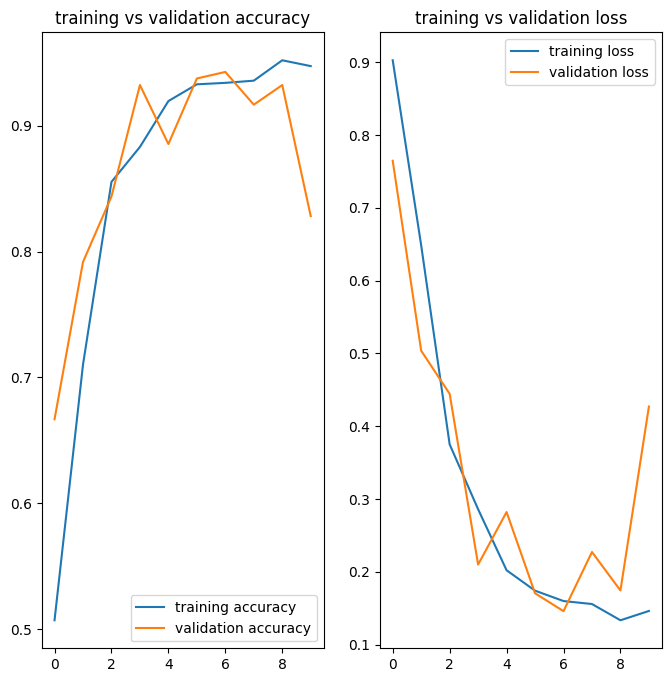

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="training accuracy")
plt.plot(range(EPOCHS), valid_acc, label="validation accuracy")
plt.legend(loc='lower right')
plt.title("training vs validation accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="training loss")
plt.plot(range(EPOCHS), valid_loss, label="validation loss")
plt.legend(loc='upper right')
plt.title("training vs validation loss")

first img to predict
acutal labe:  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
predicted label:  Potato___Early_blight


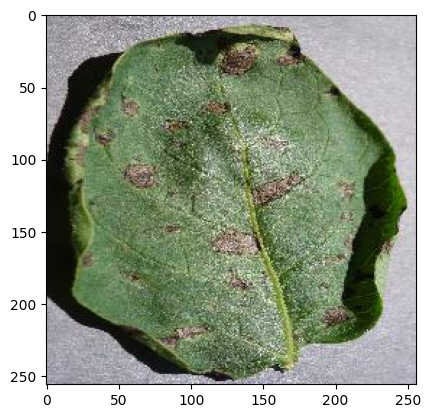

In [51]:
for images_batch, labels_batch in test_dataset.take(1):
    first_img = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first img to predict")
    plt.imshow(first_img)
    print("acutal labe: ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [64]:
def predict(model, img):
    img_array = tf.expand_dims(img, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


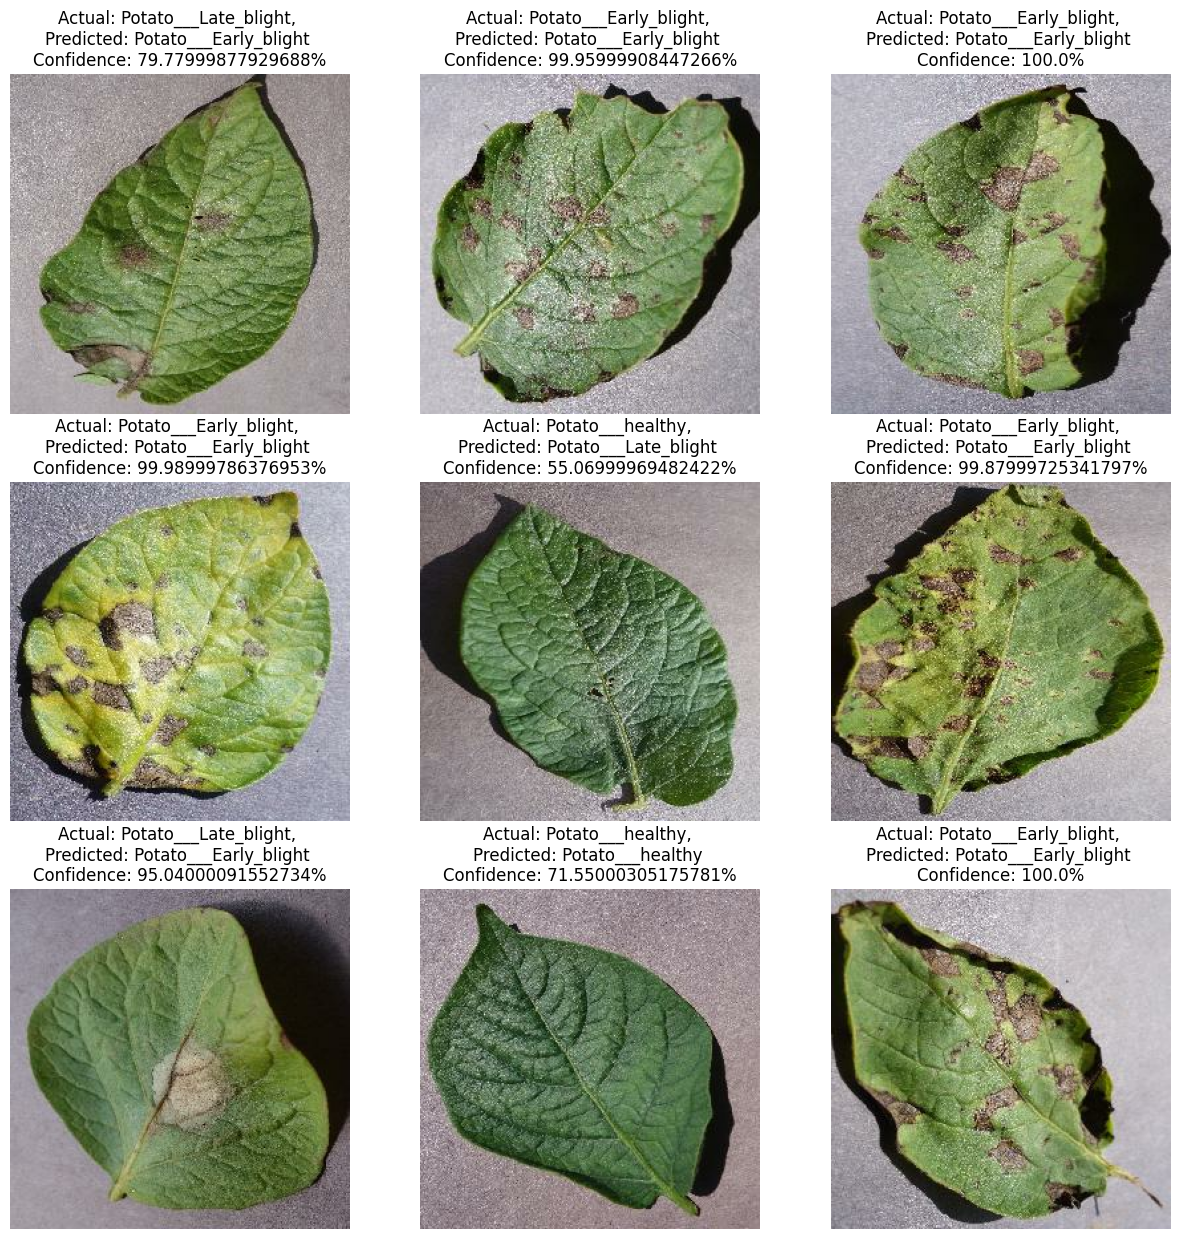

In [67]:
plt.figure(figsize=(15,15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class} \nConfidence: {confidence}%")
        plt.axis('off')
# plt.tight_layout()
# plt.show()

In [69]:
model_version=1
model.save(f"{model_version}.keras")